In [1]:
# Include so results on different machines are (should be) the same.
from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

In [2]:
!jupyter nbconvert --to script Keras_Character_MultiHeadRNN_Adjusted.ipynb

[NbConvertApp] Converting notebook Keras_Character_MultiHeadRNN_Adjusted.ipynb to script
[NbConvertApp] Writing 19666 bytes to Keras_Character_MultiHeadRNN_Adjusted.py


In [3]:
import glob, os, json, re, unicodedata
from bs4 import BeautifulSoup

load_verbose = 0
loaded_labels = []
loaded_text = []
presidents = [
    "Barack Obama",
    "Donald J. Trump",
    "Dwight D. Eisenhower",
    "Franklin D. Roosevelt",
    "George Bush",
    "George W. Bush",
    "Gerald R. Ford",
    "Harry S. Truman",
    "Herbert Hoover",
    "Jimmy Carter",
    "John F. Kennedy",
    "Lyndon B. Johnson",
    "Richard Nixon",
    "Ronald Reagan",
    "William J. Clinton"
]

labels = {}
for idx, name in enumerate(presidents):
    labels[name] = idx

# load raw text files straight in, no parsing
file_to_label = {
    "Obama": "Barack Obama",
    "Trump": "Donald J. Trump",
    "Eisenhower": "Dwight D. Eisenhower",
    "Roosevelt": "Franklin D. Roosevelt",
    "Bush": "George Bush",
    "WBush": "George W. Bush",
    "Ford": "Gerald R. Ford",
    "Truman": "Harry S. Truman",
    "Hoover": "Herbert Hoover",
    "Carter": "Jimmy Carter",
    "Kennedy": "John F. Kennedy",
    "Johnson": "Lyndon B. Johnson",
    "Nixon": "Richard Nixon",
    "Reagan": "Ronald Reagan",
    "Clinton": "William J. Clinton"
}

directory = "../data/processed/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    if any(prefix in arr[0] for prefix in file_to_label.keys()):
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 


print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."
# processed2 now contains files generated from unprocessed
directory = "../data/processed3/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    if any(prefix in arr[0] for prefix in file_to_label.keys()):
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 

print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."

Loaded 47 speeches for 14 presidents.
Loaded 1764 speeches for 15 presidents.


In [4]:
#
# Bagnall 2015 text pre-processing
#
from string import maketrans
import re

chars_to_replace = "[]%!()>=*&_}+"
sub_chars = len(chars_to_replace) * " "
trantab = maketrans(chars_to_replace, sub_chars)
for x in range(0,len(loaded_text)):
    # "Various rare characters that seemed largely equivalent are mapped together..."
    loaded_text[x] = re.sub('`', '\'', loaded_text[x])
    loaded_text[x] = re.sub('--', '-', loaded_text[x])
    loaded_text[x] = re.sub('\n\n', '\n', loaded_text[x])
    # "...all digits in all languages are mapped to 7"
    loaded_text[x] = re.sub('[0-9]+', '7', loaded_text[x])
    # "...any character with a frequency lower than 1 in 10,000 is discarded."
    loaded_text[x] = loaded_text[x].translate(trantab)
    # "Runs of whitespace are collapsed into a single space."
    loaded_text[x] = re.sub(' +', ' ', loaded_text[x])
     
    # REPLACE WORD IN ALL CAPS with <space>; headers
    loaded_text[x] = re.sub('[A-Z]{2,}','', loaded_text[x])

print "Character clean-up complete."

Character clean-up complete.


In [5]:
#
# Join all speeches into one massive per president
#  for later processing
#
import numpy as np
from scipy import stats
from operator import itemgetter
from collections import defaultdict

compressed_text = [None]*(len(labels))
for key, value in sorted(labels.iteritems()):
    compressed_text[value] = ""
    for idx in range(0,len(loaded_text)):
        if (loaded_labels[idx] == value):
            compressed_text[value] = compressed_text[value] + loaded_text[idx] + " "
            
print "How many characters of text per president?"
for key, value in sorted(labels.iteritems()):
    print str(value).ljust(2), ":", key.ljust(20), "\t", len(compressed_text[value])

label_min_chars = len(min(compressed_text, key=len))
print "\nMinimum number of characters per president?"
print label_min_chars

How many characters of text per president?
0  : Barack Obama         	4862045
1  : Donald J. Trump      	554978
2  : Dwight D. Eisenhower 	3084215
3  : Franklin D. Roosevelt 	1743457
4  : George Bush          	1896536
5  : George W. Bush       	1791014
6  : Gerald R. Ford       	687272
7  : Harry S. Truman      	2001118
8  : Herbert Hoover       	786184
9  : Jimmy Carter         	1272152
10 : John F. Kennedy      	1344012
11 : Lyndon B. Johnson    	2288606
12 : Richard Nixon        	972275
13 : Ronald Reagan        	1010291
14 : William J. Clinton   	1784166

Minimum number of characters per president?
554978


In [6]:
#
# Tokenize words into chars
#
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

# Tokenize into characters
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(compressed_text)
tokenized_text = tokenizer.texts_to_sequences(compressed_text)

# there's an oddity in the encoding for some reason where a len+1 character occurs
unique_chars = len(tokenizer.word_counts)+1

print "Unique char count:", unique_chars
print "\nChars w/ counts:"
print sorted(((v,k) for k,v in tokenizer.word_counts.iteritems()), reverse=True)

Couldn't import dot_parser, loading of dot files will not be possible.


Using TensorFlow backend.


Unique char count: 68

Chars w/ counts:
[(4725447, ' '), (2569974, 'e'), (2131220, 't'), (1627649, 'o'), (1609954, 'a'), (1476541, 'n'), (1405067, 'i'), (1193120, 's'), (1157275, 'r'), (1066798, 'h'), (755187, 'l'), (705084, 'd'), (548669, 'u'), (534278, 'c'), (478832, 'm'), (418343, 'w'), (393337, 'g'), (389784, 'f'), (382020, 'p'), (374441, 'y'), (281512, 'b'), (264600, ','), (263713, '.'), (240856, 'v'), (162701, 'I'), (151063, 'k'), (95930, "'"), (62618, 'A'), (49111, 'S'), (47587, 'T'), (44390, '-'), (40548, '7'), (39451, 'W'), (32811, 'x'), (29785, 'C'), (25503, 'j'), (23659, 'B'), (23374, 'M'), (22167, 'N'), (21726, 'q'), (21723, 'P'), (16943, 'G'), (14374, 'H'), (13620, 'U'), (12142, 'D'), (11930, 'z'), (11837, 'R'), (10677, 'F'), (10672, '"'), (10127, 'E'), (9435, 'O'), (9370, 'Y'), (9360, ';'), (8141, '?'), (7920, 'J'), (7822, 'L'), (6390, ':'), (4737, '\n'), (3981, '$'), (3943, 'K'), (3705, 'V'), (1853, '/'), (1066, 'Q'), (338, 'Z'), (80, 'X'), (6, '#'), (4, '\\')]


In [7]:
#
# Split speeches into subsequences 
#
from collections import Counter

def splits(_list, _split_size, window=False):
    output_list = []
    if (window):
        for idx in range(0, len(_list)-_split_size):
            output_list.append(_list[idx:idx + _split_size])
    else:
        for idx in range(0, len(_list), _split_size):
            if (idx + _split_size) <= len(_list):
                output_list.append(_list[idx:idx + _split_size])
    return output_list

max_seq_len = 50

# create new speech/label holders
split_text = []
split_labels = []

for idx in range(0, len(tokenized_text)):
    current_label = idx
    current_speech = tokenized_text[idx]#[:label_min_chars]
    current_splits = splits(current_speech, max_seq_len, window=False)
    split_text.extend(current_splits)
    split_labels.extend([current_label] * len(current_splits))

print "Subsequence total count; subsequence label total count:", len( split_text ), len( split_labels )
print "\nTotal characters:", len( split_text ) * max_seq_len

Subsequence total count; subsequence label total count: 521560 521560

Total characters: 26078000


In [8]:
#
# split amongst speaker samples, not the whole population of samples
#
def split_test_train(input_text, input_labels, labels, train_pct=0.8):
    train_text = []
    train_labels = []
    test_text = []
    test_labels = []

    for key, value in sorted(labels.iteritems()):
        # grab all values of a specific label
        subset_text = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_text))
        subset_labels = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_labels))
        
        cut_pos = int(train_pct * len(subset_text))
        train_text = train_text + subset_text[:cut_pos]
        train_labels = train_labels + subset_labels[:cut_pos]
        test_text = test_text + subset_text[cut_pos:]
        test_labels = test_labels + subset_labels[cut_pos:]
        
    return train_text,train_labels,test_text,test_labels

In [9]:
#
# Prep test/train
#
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight

# split data smartly
train_X, train_y, test_X, test_y = split_test_train(split_text, split_labels, 
                                                    labels, train_pct=0.9)
print "Splits:\n Test = ", len(train_X), "\n Train = ", len(test_X)##

# compute class weights to account for imbalanced classes
y_weights = (class_weight.compute_class_weight('balanced', np.unique(train_y), train_y)).tolist()
y_weights = dict(zip(sorted(labels.values()), y_weights))
print "Class weights:\n", y_weights

Splits:
 Test =  469398 
 Train =  52162
Class weights:
{0: 0.3575711869829517, 1: 3.1327660426469115, 2: 0.5636890930379177, 3: 0.99717035243133, 4: 0.9166944957084688, 5: 0.9706929710279794, 6: 2.529765561843169, 7: 0.8687970237929982, 8: 2.211533568904594, 9: 1.3666346405799634, 10: 1.2935350529100529, 11: 0.7596543185900859, 12: 1.788182857142857, 13: 1.7209194896612408, 14: 0.9744410537460297}


In [10]:
#
# One-hot encoding classes & samples
#
from keras.utils import to_categorical

# one-hot encode classes
train_y = np.array(to_categorical(train_y))
test_y = np.array(to_categorical(test_y))

# one-hot encode samples
train_X = np.array(train_X)
orig_train_X_size=train_X.shape[0]
print "Encoding train_X with dimensions ", train_X.shape
train_X = to_categorical(train_X, num_classes=unique_chars)
print "...to ", train_X.shape
train_X = np.reshape(train_X,(orig_train_X_size,max_seq_len,unique_chars))
print "...and reshaping to ", train_X.shape

test_X = np.array(test_X)
orig_test_X_size=test_X.shape[0]
print "\nEncoding test_X with dimensions ", test_X.shape
test_X = to_categorical(test_X, num_classes=unique_chars)
print "...to ", test_X.shape
test_X = np.reshape(test_X,(orig_test_X_size,max_seq_len,unique_chars))
print "...and reshaping to ", test_X.shape

Encoding train_X with dimensions  (469398, 50)
...to  (23469900, 68)
...and reshaping to  (469398, 50, 68)

Encoding test_X with dimensions  (52162, 50)
...to  (2608100, 68)
...and reshaping to  (52162, 50, 68)


In [11]:
# custom activation from Bagnall 2015
#  does not appear to perform as well as a ReLU
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects

def ReSQRT(x):
    cond = tf.less_equal(x, 0.0)
    result = tf.where(cond, x * 0.0, tf.sqrt(x+1)-1)
    return result

get_custom_objects().update({'ReSQRT': ReSQRT})

Bagnall proposes that the following possible values contribute to the success of the model:

| meta-parameter                  	| typical value                      	|
|---------------------------------	|------------------------------------	|
| initial adagrad learning scale  	| 0.1, 0.14, 0.2, 0.3                	|
| initial leakage between classes 	| 1/4N to 5/N                        	|
| leakage decay (per sub-epoch)   	| 0.67 to 0.9                        	|
| hidden neurons                  	| 79, 99, 119, 139                   	|
| presynaptic noise σ             	| 0, 0.1, 0.2, 0.3, 0.5              	|
| sub-epochs                      	| 6 to 36                            	|
| text direction                  	| forward or backward                	|
| text handling                   	| sequential, concatenated, balanced 	|
| initialisation                  	| gaussian, zero                     	|

In [12]:
##
## Multi-head RNN
##
from keras.layers import Input, Dense, SimpleRNN, Bidirectional
from keras.layers.merge import Maximum, Add, Concatenate
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from keras.layers.merge import Average, Maximum
from keras.optimizers import Adamax, RMSprop
from keras.models import Model
from keras.utils import plot_model

# set parameters; determined by optimization @ end
init_modes = 'glorot_uniform'
batch_size = unique_chars
units = unique_chars
dropout = 0.5
activation = 'relu'
merge_mode = 'sum'
shuffle = True

optimizer = Adamax(lr=0.01) 

epochs = 50

# define any callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', 
                              factor=0.1,
                              patience=1, 
                              verbose=1)
csv_logger = CSVLogger('Keras_Character_MultiHeadRNN_Adjusted.log')

# assemble & compile model
main_inputs = []
for x in range(0,len(labels)):
    main_inputs.append( Input(shape=(max_seq_len,unique_chars,)) )

rnns = []
for x in range(0,len(labels)):
    rnns.append(Bidirectional(SimpleRNN(units=units,
                                        activation=activation,
                                        recurrent_dropout=dropout,
                                        kernel_initializer=init_modes),
                              merge_mode=merge_mode)
                (main_inputs[x]))

dense_layers = []
for x in range(0,len(labels)):
    dense_layers.append(Dense(1,
                              activation='sigmoid',
                              kernel_initializer=init_modes)
                        (rnns[x]))

final_out = Concatenate()(dense_layers)

model = Model(inputs=main_inputs, 
              outputs=[final_out])

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])
plot_model(model, to_file='Keras_Character_MultiHeadRNN_Adjusted.png', show_shapes=True, show_layer_names=True)
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 50, 68)        0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 50, 68)        0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 50, 68)        0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 50, 68)        0                                            
___________________________________________________________________________________________

In [ ]:
# adjust training for new model
train_y_flat = []
for x in range(0,len(labels)):
    train_y_flat.append((train_y[:,x] == 1).astype(np.int))
print
print len(train_y_flat[0])

test_y_flat = []
for x in range(0,len(labels)):
    test_y_flat.append((test_y[:,x] == 1).astype(np.int))
print len(test_y_flat[0])



469398
52162


In [ ]:
# train the model

all_training = []
for x in range(0,len(labels)):
    all_training.append(np.asarray(train_X))
    
model.fit(all_training,
          [np.swapaxes(np.asarray(train_y_flat),0,1)],
          batch_size=batch_size,
          epochs=epochs,
          #shuffle=shuffle,
          class_weight = y_weights,
          callbacks=[reduce_lr, csv_logger],
          verbose=1)

model.save('Keras_Character_MultiHeadRNN_Adjusted.h5')
print ("Model saved.")
del model

Epoch 1/50
   748/469398 [..............................] - ETA: 6677s - loss: 1.5949 - acc: 0.8532

In [ ]:
##
## MODEL EVALUATION
##

In [363]:
### Load computed model
from keras.models import load_model
# returns a compiled model identical to the one trained
model = load_model('Keras_Character_MultiHeadRNN_Adjusted.h5')
print "Model loaded." 

Model loaded.


In [379]:
from sklearn import metrics

batch_size = 50

all_test = []
for x in range(0,len(labels)):
    all_test.append(np.asarray(test_X))
    
# Evaluate performance
print "Evaluating test data..."
loss_and_metrics = model.evaluate(all_test,[np.swapaxes(np.asarray(test_y_flat),0,1)])
print "\n", model.metrics_names
print "\n", loss_and_metrics

Evaluating test data...
52160/52162 [============================>.] - ETA: 0s
['loss', 'acc']

[0.35394050324718707, 0.93332950304697304]


In [382]:
# Make some predictions
print "Predicting using test data..."
pred_y = model.predict(all_test,batch_size=batch_size, verbose=1)
print "\n\nDone prediction."

Predicting using test data...
52150/52162 [============================>.] - ETA: 0s

Done prediction.


In [384]:
from sklearn.metrics import accuracy_score

pred_y_collapsed = np.argmax(pred_y, axis=1)
test_y_collapsed = np.argmax(test_y, axis=1)

print "Predict accuracy = ", accuracy_score(test_y_collapsed,pred_y_collapsed)
# print "\nAUC = ", metrics.roc_auc_score(test_y_collapsed, pred_y_collapsed)

Predict accuracy =  0.159138836701
0.159138836701


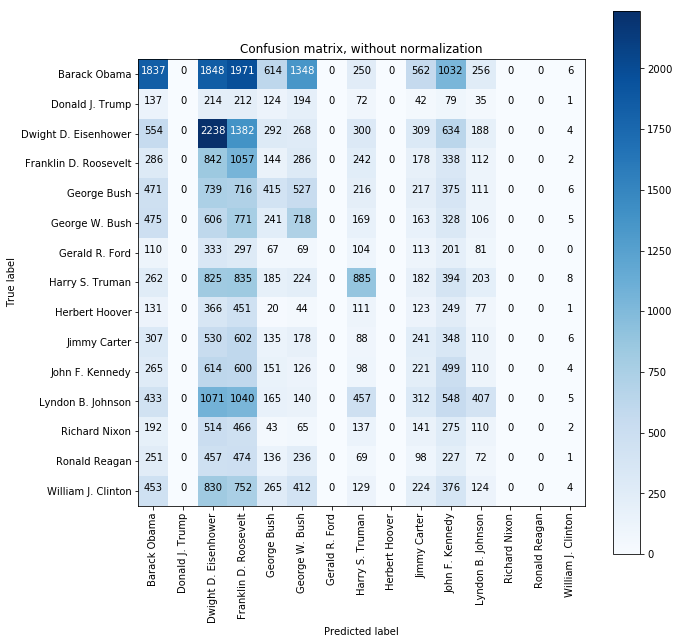

In [367]:
# Plot confusion matrix
#   from scikit-learn examples @
#   http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y_collapsed, pred_y_collapsed)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)),
                      title='Confusion matrix, without normalization')

plt.show()

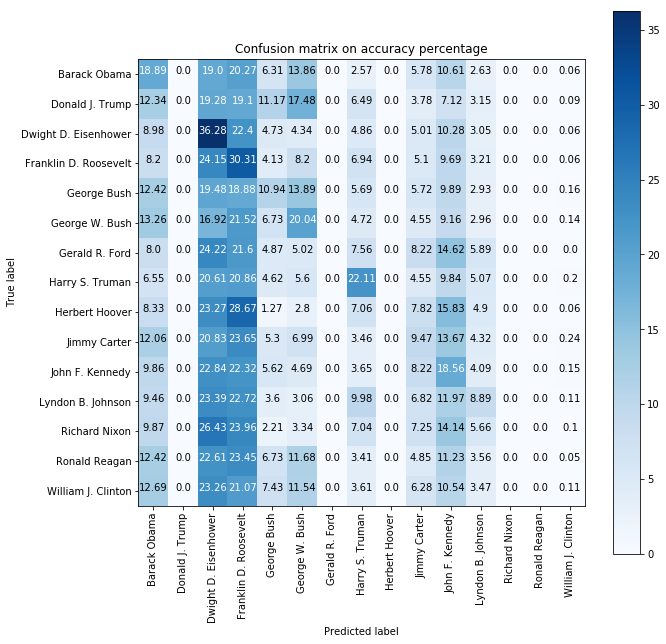

In [368]:
#Plot normalized confusion matrix
cnf_matrix_pct = cnf_matrix *1.0
cnf_matrix_pct = np.around(np.array([row*100.0/sum(row) for row in cnf_matrix_pct]), 2)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix_pct, classes=(sorted(labels, key=labels.get)),
                      title='Confusion matrix on accuracy percentage')
plt.show()

In [ ]:
sample_idx = 20000
print(pred_y[sample_idx])
print(test_y[sample_idx])

inv_labels = {v: k for k, v in labels.iteritems()}
print "Predicted:", inv_labels[np.argmax(pred_y[sample_idx])], "\tActual:", inv_labels[np.argmax(test_y[sample_idx])]
#print split_text[sample_idx-1:sample_idx+1]

# print one sequence on either side of confused
sample = split_text[sample_idx-1:sample_idx+1]
sample = sum(sample, [])
sample_txt = ""
tokenizer_rev = {v: k for k, v in tokenizer.word_index.items()}
for char in sample:
    sample_txt += tokenizer_rev[char]
print sample_txt

In [ ]:
binwidth = .05
#pred_outs = pred_y/len(labels)
plt.hist(pred_y.max(axis=1),bins=np.arange(0.0, 0.5, 0.01))
plt.title('Frequency of predicted max probability per sequence')
plt.show()

In [ ]:
##
## MODEL OPTIMIZATION
##

In [ ]:
# from keras.layers import Input, Dense, SimpleRNN, Bidirectional
# from keras.layers.merge import Maximum, Add, Concatenate
# from keras.callbacks import ReduceLROnPlateau, CSVLogger
# from keras.layers.merge import Average, Maximum
# from keras.optimizers import Adagrad, adam
# from keras.models import Model

# from sklearn.model_selection import GridSearchCV
# from keras.wrappers.scikit_learn import KerasClassifier

# # define operating vars
# # activation = "relu" #"ReSQRT" 
# # units = 150# 50
# # dropout = 0.0 #0.7646166765488501
# # batch_size = 50# 100
# # epochs = 100
# # optimizer='adamax'#'rmsprop'
# # shuffle=True #False

# def create_model(optimizer='rmsprop', learn_rate=0.01,
#                  init_mode1='glorot_uniform', init_mode2='glorot_uniform', 
#                  merge_mode='ave', activation='relu', 
#                  dropout_rate=0.0, neuron_count=50):

#     # assemble & compile model
#     input = Input(shape=(max_seq_len,unique_chars,))
#     rnn = Bidirectional(SimpleRNN(units=neuron_count,
#                                   activation=activation,
#                                   recurrent_dropout=dropout_rate,
#                                   kernel_initializer=init_mode1),
#                         merge_mode=merge_mode)(input)
    
#     soft_out = []
#     for idx in range(0,len(labels)):
#         soft_out.append(Dense(len(labels),
#                               activation='softmax', 
#                               kernel_initializer=init_mode2)(rnn))
#     final_out = Add()(soft_out)

#     model = Model(inputs=[input], outputs = final_out) 

#     model.compile(loss='categorical_crossentropy', 
#                   optimizer=optimizer, 
#                   metrics=['accuracy'])

#     return model


# # instantiate model
# model = KerasClassifier(build_fn=create_model, verbose=1)

# # define the grid search parameters
# epoch = [2]
# batch_sizes = [25,50,75]
# optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adamax']
# init_modes1 = ['uniform', 'normal', 'zero']
# merge_modes = ['sum', 'mul', 'concat', 'ave']
# activations = ['relu','tanh']
# dropout_rates = [0.0,0.5,0.9]
# neuron_counts = [25,50,75]
# learn_rates = [0.01,0.1,0.2]
# param_grid = dict(batch_size=batch_sizes,
#                   epochs=epoch,
#                   optimizer=optimizers,
#                   learn_rate=learn_rates,
#                   init_mode1=init_modes1,
#                   init_mode2=init_modes2,
#                   merge_mode=merge_modes,
#                   activation=activations,
#                   dropout_rate=dropout_rates,
#                   neuron_count=neuron_counts)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, verbose=2, cv=2)
# grid_result = grid.fit(train_X, train_y)

# # summarize results
# # from http://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))